In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sunpy 
import sunpy.map
from sunpy.coordinates import Helioprojective, propagate_with_solar_surface
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import eispac
from astropy.visualization import ImageNormalize, AsinhStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy import constants as const
from sun_blinker import SunBlinker
from regions import (PolygonSkyRegion,)

In [2]:
eis_pointing_save = np.load('../../src/EIS/eis_pointing/eis_20221026_071350/pointing_verification/20221026_071350/intensity_data_step_3_optimal.npz',allow_pickle=True)

In [3]:
eis_pointing_x = eis_pointing_save['x']
eis_pointing_y = eis_pointing_save['y']

In [4]:
eis_pointing_x.shape

(512, 62)

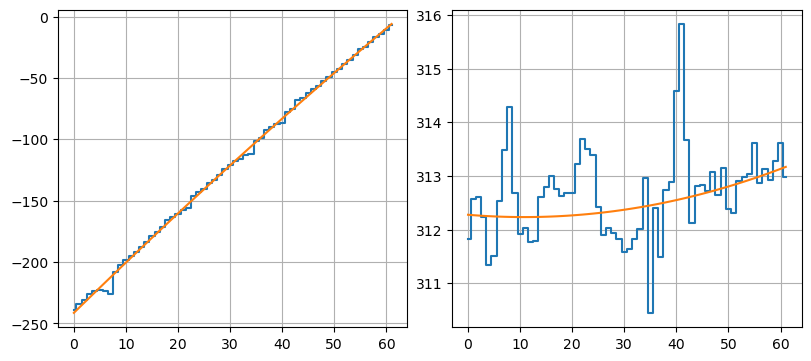

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5),layout='constrained')
ax1.step(np.arange(62),eis_pointing_x[380,:],where='mid')
ax2.step(np.arange(62),eis_pointing_y[380,:],where='mid')
fit_x = np.polyfit(np.arange(62),eis_pointing_x[380,:],2)
fit_y = np.polyfit(np.arange(62)[np.r_[0:6,10:39,44:62]],eis_pointing_y[380,np.r_[0:6,10:39,44:62]],2)
ax1.plot(np.arange(62),np.polyval(fit_x,np.arange(62)))
ax2.plot(np.arange(62),np.polyval(fit_y,np.arange(62)))


for ax_ in (ax1,ax2):
    ax_.grid(True)


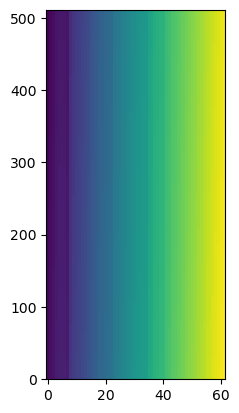

In [6]:
plt.imshow(eis_pointing_x,aspect=1/4,origin='lower',interpolation='none')

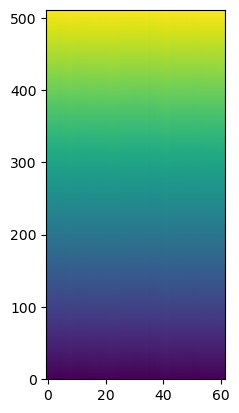

In [7]:
plt.imshow(eis_pointing_y,aspect=1/4,origin='lower', interpolation='none')

In [8]:
eis_pointing_x_fix = np.zeros_like(eis_pointing_x)
eis_pointing_y_fix = np.zeros_like(eis_pointing_y)

In [9]:
good_x_pos = np.r_[0:6,10:39,44:62]
for ii in range(512):
    fix_x_ = np.polyfit(good_x_pos,eis_pointing_x[ii,good_x_pos],2)
    fix_y_ = np.polyfit(good_x_pos,eis_pointing_y[ii,good_x_pos],2)

    eis_pointing_x_fix[ii,:] = np.polyval(fix_x_,np.arange(62))
    eis_pointing_y_fix[ii,:] = np.polyval(fix_y_,np.arange(62))

# eis_pointing_x_fix = eis_pointing_x
# eis_pointing_y_fix = eis_pointing_y

In [10]:
y_interp = np.linspace(eis_pointing_y_fix.min(), eis_pointing_y_fix.max(), eis_pointing_y_fix.shape[0])
x_interp = np.linspace(eis_pointing_x_fix.min(), eis_pointing_x_fix.max(), eis_pointing_x_fix.shape[1])

In [11]:
eis_195_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221026T0713/eis_20221026_071350.fe_12_195_119.1c-0.fit.h5")
eis_195_intmap = eis_195_fitres.get_map()

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221026T0713/eis_20221026_071350.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


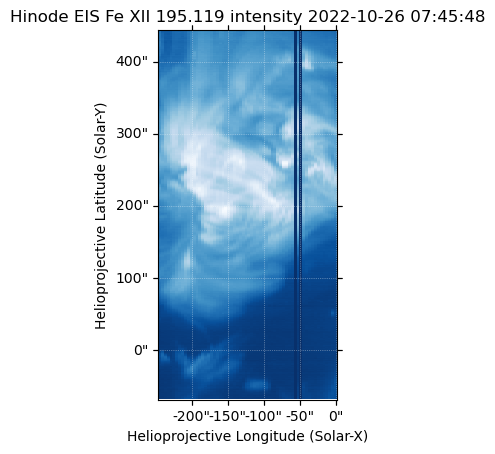

In [12]:
eis_195_intmap.plot()

In [13]:
xi_interp = np.moveaxis(np.array(np.meshgrid(x_interp, y_interp)), 0, -1)
points = (eis_pointing_x_fix.flatten(), eis_pointing_y_fix.flatten())

In [14]:
eis_int_interp_linear_func = LinearNDInterpolator(points, eis_195_intmap.data.flatten())
eis_int_interp_linear = eis_int_interp_linear_func(xi_interp)

In [15]:
interp_dx = (x_interp[-1] - x_interp[0])/(x_interp.shape[0] - 1)
interp_dy = (y_interp[-1] - y_interp[0])/(y_interp.shape[0] - 1)
interp_extent = [x_interp.min() - interp_dx/2, x_interp.max() + interp_dx/2, y_interp.min() - interp_dy/2, y_interp.max() + interp_dy/2]

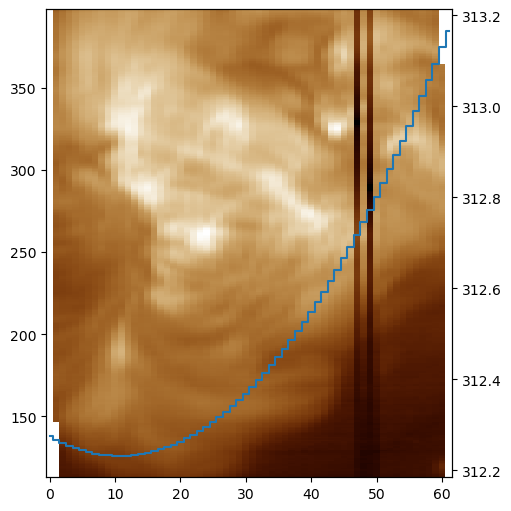

In [16]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')
ax.imshow(eis_int_interp_linear, norm=ImageNormalize(stretch=AsinhStretch()),
          origin='lower', cmap='sdoaia193',interpolation='none',aspect=eis_195_intmap.scale.axis2/eis_195_intmap.scale.axis1,)
ax_twin = ax.twinx()
ax_twin.step(np.arange(62),eis_pointing_y_fix[380,:],where='mid')

In [17]:
def xy_to_wcs(x,y,data,date_obs,instrument,observatory):
    nx = data.shape[1]
    ny = data.shape[0]
    wcs_header = sunpy.map.make_fitswcs_header(data,
                                               coordinate=SkyCoord(x[nx//2], y[ny//2], unit=u.arcsec,
                                                                             frame="helioprojective", obstime=date_obs,
                                                                             rsun=696000000.0*u.m),
                                                reference_pixel=[nx//2, ny//2]*u.pix,
                                            scale=[np.abs(x[-1] - x[0])/(nx - 1), np.abs(y[-1] - y[0])/(ny - 1)] * u.arcsec/u.pix,
                                            instrument=instrument,
                                            observatory=observatory,
                                            ) 
    return WCS(wcs_header)                                                  
    


In [18]:
eis_interp_wcs = xy_to_wcs(x_interp, y_interp, eis_int_interp_linear, eis_195_intmap.date_average, 'EIS', 'Hinode')

In [19]:
eis_195_int_interp_linear_map = sunpy.map.Map(eis_int_interp_linear, eis_interp_wcs)
eis_195_int_interp_linear_map.plot_settings["aspect"] = eis_195_int_interp_linear_map.scale.axis2/eis_195_int_interp_linear_map.scale.axis1
eis_195_int_interp_linear_map.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch())
eis_195_int_interp_linear_map.plot_settings["cmap"] = 'sdoaia193'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


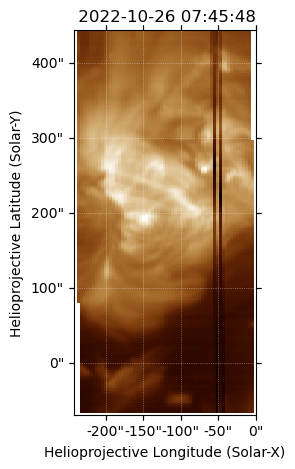

In [20]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection=eis_195_int_interp_linear_map)
eis_195_int_interp_linear_map.plot(axes=ax, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))

In [21]:
eis_195_intmap.meta['date_obs'], eis_195_intmap.meta['date_avg']

('2022-10-26T07:13:50.000', '2022-10-26T07:45:48.500')

In [22]:
aia_193_0745 = sunpy.map.Map('../../src/AIA/20221026/193/lvl15/aia.lev1_euv_12s.2022-10-26T074551Z.193.image.fits')
aia_193_0713 = sunpy.map.Map('../../src/AIA/20221026/193/lvl15/aia.lev1_euv_12s.2022-10-26T071351Z.193.image.fits')

In [23]:
with propagate_with_solar_surface(rotation_model='rigid'):
    aia_193_0745_repro = aia_193_0745.reproject_to(eis_195_int_interp_linear_map.wcs)
    aia_193_0713_repro = aia_193_0713.reproject_to(eis_195_int_interp_linear_map.wcs)

In [24]:
aia_193_0745_repro.plot_settings["aspect"] = aia_193_0745_repro.scale.axis2/aia_193_0745_repro.scale.axis1
aia_193_0713_repro.plot_settings["aspect"] = aia_193_0713_repro.scale.axis2/aia_193_0713_repro.scale.axis1

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


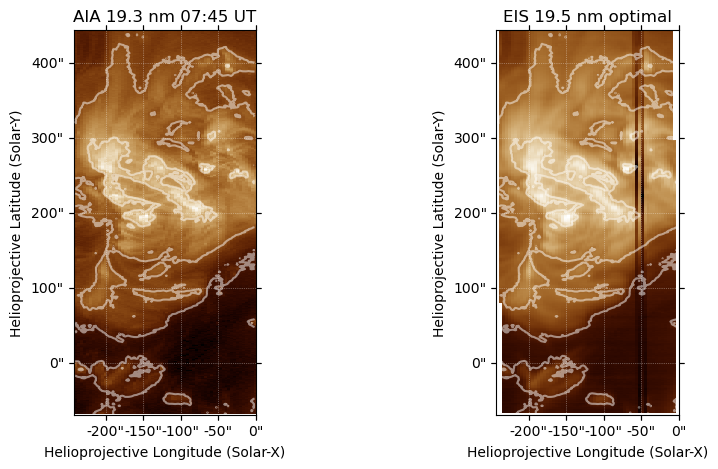

In [25]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121,projection=aia_193_0745_repro)
aia_193_0745_repro.plot(axes=ax1, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))
ax1.set_title('AIA 19.3 nm 07:45 UT')

ax2 = plt.subplot(122,projection=eis_195_int_interp_linear_map)
eis_195_int_interp_linear_map.plot(axes=ax2, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))
ax2.set_title('EIS 19.5 nm optimal')

for ax_ in (ax1,ax2):
    aia_193_0745_repro.draw_contours(levels=[90,300,1000], colors='w', axes=ax_,alpha=0.5,lw=0.5)



/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


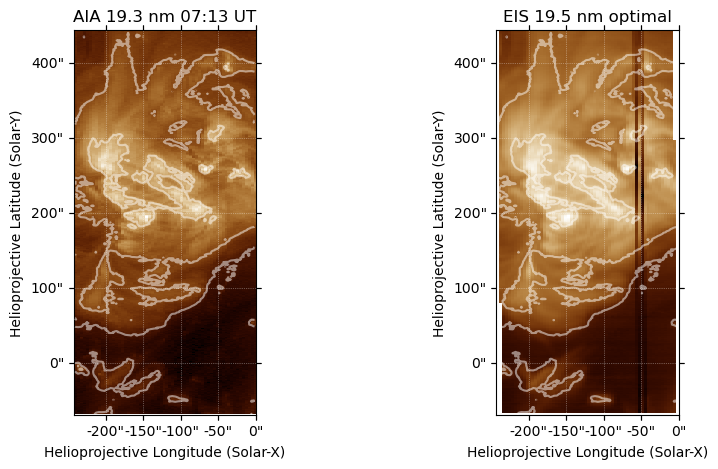

In [26]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121,projection=aia_193_0713_repro)
aia_193_0713_repro.plot(axes=ax1, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))
ax1.set_title('AIA 19.3 nm 07:13 UT')

ax2 = plt.subplot(122,projection=eis_195_int_interp_linear_map)
eis_195_int_interp_linear_map.plot(axes=ax2, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))
ax2.set_title('EIS 19.5 nm optimal')

for ax_ in (ax1,ax2):
    aia_193_0713_repro.draw_contours(levels=[100,300,1000], colors='w', axes=ax_,alpha=0.5,lw=0.5)



In [27]:
SunBlinker(eis_195_int_interp_linear_map, aia_193_0745_repro,figsize=(4,5))

In [28]:
SunBlinker(eis_195_int_interp_linear_map, aia_193_0713_repro,figsize=(4,5))

In [29]:
def solar_rotation_compensate_xy_interp(x, y, date_start, date_end, date_average):
    nx = x.shape[1]
    ny = y.shape[0]

    x_derot = np.zeros_like(x)
    y_derot = np.zeros_like(y)

    # EIS scans from west to east
    date_grid = np.linspace(date_end, date_start, nx)

    unify_helioprojective_frame = Helioprojective(observer='earth', obstime=date_average,rsun=696000000.0*u.m)


    for ii in range(nx):
        helioprojective_frame_ii = Helioprojective(observer='earth', obstime=date_grid[ii],rsun=696000000.0*u.m)
        coords_ii = SkyCoord(x[:,ii]*u.arcsec, y[:,ii]*u.arcsec, frame=helioprojective_frame_ii)
        with propagate_with_solar_surface(rotation_model='rigid'):
            coords_ii_unified = coords_ii.transform_to(unify_helioprojective_frame)
        x_derot[:,ii] = coords_ii_unified.Tx.to_value(u.arcsec)
        y_derot[:,ii] = coords_ii_unified.Ty.to_value(u.arcsec)
    
    x_interp = np.linspace(x_derot.min(), x_derot.max(), nx)
    y_interp = np.linspace(y_derot.min(), y_derot.max(), ny)

    return x_derot, y_derot, x_interp, y_interp    

In [30]:
eis_pointing_x_derot, eis_pointing_y_derot, x_interp_derot, y_interp_derot = \
    solar_rotation_compensate_xy_interp(eis_pointing_x_fix, eis_pointing_y_fix, eis_195_intmap.date_start, eis_195_intmap.date_end, eis_195_intmap.date_average)

In [31]:
xi_interp_derot = np.moveaxis(np.array(np.meshgrid(x_interp_derot, y_interp_derot)), 0, -1)
points_derot = (eis_pointing_x_derot.flatten(), eis_pointing_y_derot.flatten())

eis_int_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_intmap.data.flatten())
eis_int_interp_linear_derot = eis_int_interp_linear_func_derot(xi_interp_derot)

interp_dx_derot = (x_interp_derot[-1] - x_interp_derot[0])/(x_interp_derot.shape[0] - 1)
interp_dy_derot = (y_interp_derot[-1] - y_interp_derot[0])/(y_interp_derot.shape[0] - 1)

interp_extent_derot = [x_interp_derot.min() - interp_dx_derot/2, x_interp_derot.max() + interp_dx_derot/2,
                        y_interp_derot.min() - interp_dy_derot/2, y_interp_derot.max() + interp_dy_derot/2]

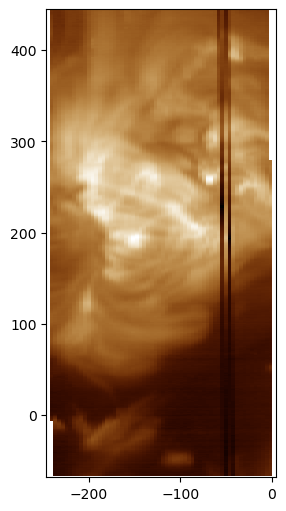

In [32]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')
ax.imshow(eis_int_interp_linear_derot, extent=interp_extent_derot, norm=ImageNormalize(stretch=AsinhStretch()),
          origin='lower', cmap='sdoaia193',interpolation='none')


In [33]:
eis_interp_wcs_derot = xy_to_wcs(x_interp_derot, y_interp_derot, eis_int_interp_linear_derot, eis_195_intmap.date_average, 'EIS', 'Hinode')

In [34]:
eis_195_int_interp_linear_map_derot = sunpy.map.Map(eis_int_interp_linear_derot, eis_interp_wcs_derot)
eis_195_int_interp_linear_map_derot.plot_settings["aspect"] = eis_195_int_interp_linear_map_derot.scale.axis2/eis_195_int_interp_linear_map_derot.scale.axis1
eis_195_int_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch())
eis_195_int_interp_linear_map_derot.plot_settings["cmap"] = 'sdoaia193'


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = super().contour(*args, **kwargs)


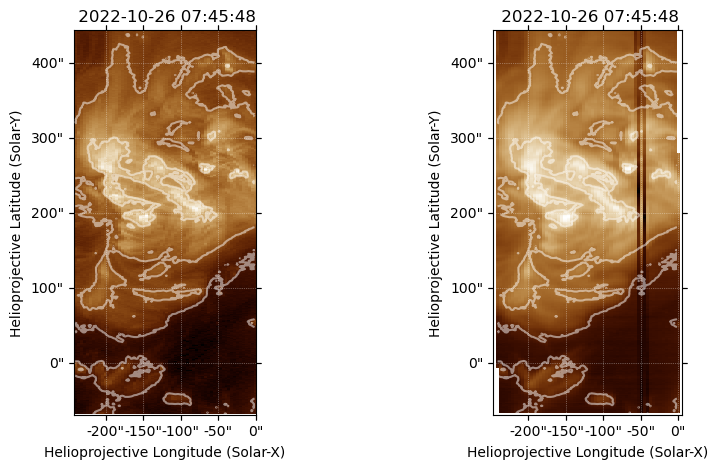

In [35]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(121,projection=aia_193_0745_repro)
aia_193_0745_repro.plot(axes=ax1, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))

ax2 = plt.subplot(122,projection=eis_195_int_interp_linear_map_derot)
eis_195_int_interp_linear_map_derot.plot(axes=ax2, cmap='sdoaia193', norm=ImageNormalize(stretch=AsinhStretch()))

for ax_ in (ax1,ax2):
    aia_193_0745_repro.draw_contours(levels=[90,300,1000], colors='w', axes=ax_,alpha=0.5,lw=0.5)

In [36]:
SunBlinker(eis_195_int_interp_linear_map_derot, aia_193_0745, reproject=True,figsize=(4,5))

In [37]:
eis_195_velmap = eis_195_fitres.get_map(measurement='velocity')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [38]:
eis_195_vel_interp_linear_func_derot = LinearNDInterpolator(points_derot, eis_195_velmap.data.flatten())
eis_195_vel_interp_linear_derot = eis_195_vel_interp_linear_func_derot(xi_interp_derot)

eis_195_vel_interp_nearest_func_derot = NearestNDInterpolator(points_derot, eis_195_velmap.data.flatten())
eis_195_vel_interp_nearest_derot = eis_195_vel_interp_nearest_func_derot(xi_interp_derot)

Text(0.5, 1.0, 'Nearest Interpolation')

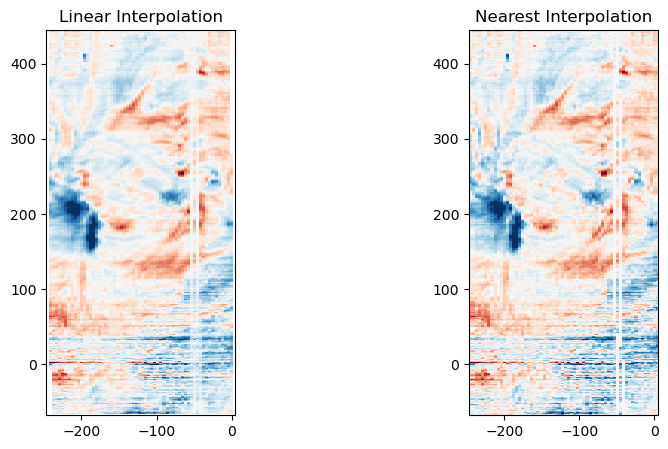

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(eis_195_vel_interp_linear_derot, extent=interp_extent_derot, origin='lower', cmap='RdBu_r',interpolation='none',
           norm=ImageNormalize(vmin=-15,vmax=15))

ax1.set_title('Linear Interpolation')

ax2.imshow(eis_195_vel_interp_nearest_derot, extent=interp_extent_derot, origin='lower', cmap='RdBu_r',interpolation='none',
           norm=ImageNormalize(vmin=-15,vmax=15))
ax2.set_title('Nearest Interpolation')

In [40]:
eis_195_vel_interp_linear_map_derot = sunpy.map.Map(eis_195_vel_interp_linear_derot, eis_interp_wcs_derot)

In [41]:
eis_195_vel_interp_linear_map_derot.plot_settings["aspect"] = eis_195_vel_interp_linear_map_derot.scale.axis2/eis_195_vel_interp_linear_map_derot.scale.axis1
eis_195_vel_interp_linear_map_derot.plot_settings["norm"] = ImageNormalize(vmin=-15,vmax=15)
eis_195_vel_interp_linear_map_derot.plot_settings["cmap"] = 'RdBu_r'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


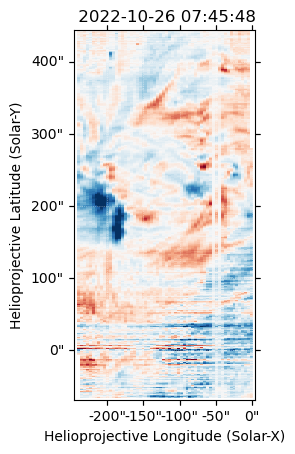

In [42]:
eis_195_vel_interp_linear_map_derot.plot()

In [43]:
eis_195_widmap = eis_195_fitres.get_map(measurement='width')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


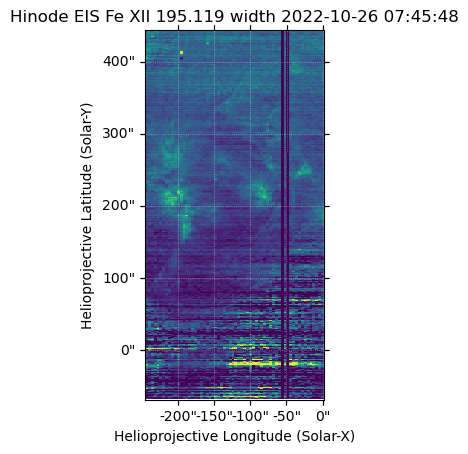

In [44]:
eis_195_widmap.plot(vmin=0.03,vmax=0.04)

In [45]:
eis_195_true_width = np.sqrt( (eis_195_widmap.data * np.sqrt(8*np.log(2)))**2 - (eis_195_fitres.meta["slit_width"][:,np.newaxis])**2)
eis_195_v1oe = eis_195_true_width*u.angstrom/np.sqrt(4*np.log(2))*const.c/(195.119*u.angstrom)
vth2 = 2*const.k_B*(10**6.2)*u.K/const.u/55.85
vnth = np.sqrt(eis_195_v1oe**2 - vth2).to(u.km/u.s)

/tmp/ipykernel_99270/1809368226.py:1: RuntimeWarning: invalid value encountered in sqrt
  eis_195_true_width = np.sqrt( (eis_195_widmap.data * np.sqrt(8*np.log(2)))**2 - (eis_195_fitres.meta["slit_width"][:,np.newaxis])**2)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [46]:
eis_195_wid_interp_linear_func_derot = LinearNDInterpolator(points_derot, vnth.flatten())
eis_195_wid_interp_linear_derot = eis_195_wid_interp_linear_func_derot(xi_interp_derot)

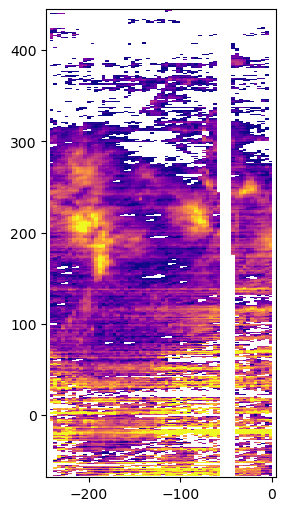

In [47]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')

ax.imshow(eis_195_wid_interp_linear_derot, extent=interp_extent_derot, origin='lower', cmap='plasma',interpolation='none',
           norm=ImageNormalize(vmin=10,vmax=40))

In [48]:
eis_195_wid_interp_linear_derot_map = sunpy.map.Map(eis_195_wid_interp_linear_derot, eis_interp_wcs_derot)

eis_195_wid_interp_linear_derot_map.plot_settings["aspect"] = eis_195_wid_interp_linear_derot_map.scale.axis2/eis_195_wid_interp_linear_derot_map.scale.axis1
eis_195_wid_interp_linear_derot_map.plot_settings["norm"] = ImageNormalize(vmin=10,vmax=40)
eis_195_wid_interp_linear_derot_map.plot_settings["cmap"] = 'magma'

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


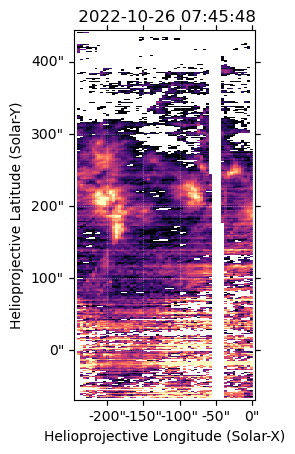

In [49]:
eis_195_wid_interp_linear_derot_map.plot()

In [50]:
eis_195_int_interp_linear_map_derot.save("../../src/EIS/DHB_007_v2/20221026T0713/sunpymaps/eis_195_intmap_shift.fits",overwrite=True)
eis_195_vel_interp_linear_map_derot.save("../../src/EIS/DHB_007_v2/20221026T0713/sunpymaps/eis_195_velmap_shift.fits",overwrite=True)
eis_195_wid_interp_linear_derot_map.save("../../src/EIS/DHB_007_v2/20221026T0713/sunpymaps/eis_195_widmap_shift.fits",overwrite=True)

/tmp/ipykernel_99270/4048885994.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.0)


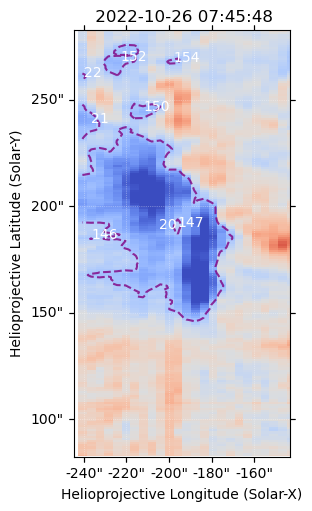

In [51]:
fig = plt.figure(figsize=(3,5),layout='constrained')

ax = plt.subplot(projection=eis_195_vel_interp_linear_map_derot)
eis_195_vel_interp_linear_map_derot.plot(axes=ax, cmap='coolwarm', norm=ImageNormalize(vmin=-15,vmax=15))

ax.set_xlim(0,25)
ax.set_ylim(150,350)

cs_eis_1026 = eis_195_vel_interp_linear_map_derot.draw_contours(levels=[-5,],colors=["purple"],axes=ax,alpha=0.8)

for ii, seg in enumerate(cs_eis_1026.allsegs[0]):
    if np.nanmean(seg, axis=0)[0] > 0 and np.nanmean(seg, axis=0)[0] < 20 and \
        np.nanmean(seg, axis=0)[1] > 150 and np.nanmean(seg, axis=0)[1] < 350:
        ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)


plt.subplots_adjust(bottom=0.0)

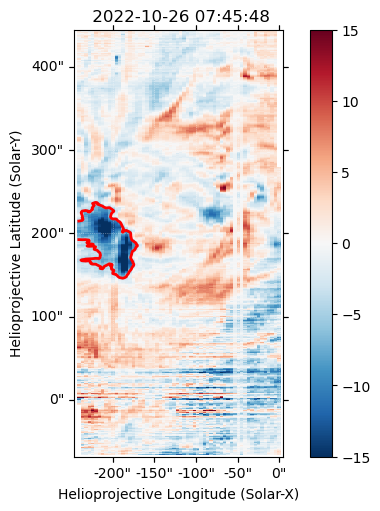

In [52]:
cs_selected_index_1026 = [20]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_195_vel_interp_linear_map_derot)
eis_195_vel_interp_linear_map_derot.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1026:
    ax.plot(*cs_eis_1026.allsegs[0][ii].T, color='red', lw=2)

In [53]:
cs_skycoords_eis_1026 = [eis_195_vel_interp_linear_map_derot.pixel_to_world(cs_eis_1026.allsegs[0][cs_selected_index_1026[0]][:,0]*u.pix,
                                                    cs_eis_1026.allsegs[0][cs_selected_index_1026[0]][:,1]*u.pix) \
                ]
cs_regions_eis_1026 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_eis_1026]

In [54]:
cs_regions_eis_1026[0].to_pixel(eis_195_vel_interp_linear_map_derot.wcs).write('../../sav/regions/eis_1026_east_pixel.reg',overwrite=True)